In [1]:
%run constants.ipynb

In [2]:
def euclidean_distance(first, second):
    deltas = first - second
    return np.sqrt(np.sum(deltas * deltas, axis = -1))

def cosine_distance(first, second, epsilon = 1e-6):
    first_abs = np.sqrt(np.sum(first * first, axis = -1))
    second_abs = np.sqrt(np.sum(second * second, axis = -1))
    return 1.0 - np.sum(first * second, axis = -1) / (first_abs * second_abs + epsilon)


def get_color_degrees(colors, images):
    first = colors[:, np.newaxis, np.newaxis, np.newaxis, :]
    second = images[np.newaxis, :, :, :, :]
    
    distances = euclidean_distance(first, second) + \
                2.0 * cosine_distance(first, second)
    distances = distances.reshape([distances.shape[0], distances.shape[1], -1])
   
    distances = np.sort(distances, axis = 2)
    percentage = 0.6
    weights = np.exp(-np.linspace(0, 1, distances.shape[2]) / percentage)
    folds = np.sum(distances * weights[np.newaxis, np.newaxis, :], axis = 2)
    return folds

In [3]:
import pickle
from skimage.io import imread
import tqdm
import scipy.misc

def read_all(path_to_distances, path_to_images):
    with open(path_to_distances, "rb") as f:
        data = pickle.load(f)
    distances = data[1]
    ids = data[0]
    
   
    names = []
    for id_now in ids:
        names.append(str(id_now) + ".png")
        
    images = []
    for i in tqdm.tqdm(range(len(names))):
        if ("png" in names[i]):
            try:
                image_now = imread(path_to_images + '/' + names[i])
                images.append(scipy.misc.imresize(image_now, [150, 150]) / 255.0)
            except:
                print(names[i] + " is bad")
    images = np.array(images)[:magic_constant]
    distances = distances[:magic_constant, :magic_constant]
    return ids, images, distances

In [4]:
from sklearn.cluster import  FeatureAgglomeration, SpectralClustering
def compute_clusters(distances):
    np.random.seed(0)
    
    n_clusters = 6
    clst = SpectralClustering(affinity='precomputed',\
                              n_clusters = n_clusters)
    delta = np.mean(np.power(distances, 0.35))
    similarities = np.exp(-np.power(distances, 0.35) / delta * 0.6)
    clst.fit(similarities)

   
    return n_clusters, clst.labels_

In [5]:
import tqdm

class TexturesBackend:
    def __init__(self, path_to_distances, path_to_pictures):
        self.ids, self.images, self.distances = read_all(path_to_distances, 
                                          path_to_pictures)
        
        self.ids = np.array(self.ids)[0:magic_constant]
        self.invert_index = {}
        for i in range(len(self.ids)):
            self.invert_index[self.ids[i]] = i
        
        print(self.images.shape)
        self.color_distances = get_color_degrees(COLORS, self.images)
        
        self.n_clusters, self.labels_ = compute_clusters(self.distances)
    
       
    def get_initial_images(self, color_id):
        #print(self.color_distances.shape)

        result = []
        relevant_color_distances = self.color_distances[color_id]
        #print(relevant_color_distances[:5])
        #print(color_id)
        for cluster_ind in range(self.n_clusters):
            mask = (self.labels_ == cluster_ind)
            distances_now = relevant_color_distances[mask]
            ids_now = self.ids[mask]
            #print(distances_now[:5])
            need = np.argsort(distances_now)[0]
            #print(need)
            result.append([self.images[mask][need], ids_now[need]])
        return result
    
    def get_best(self, color_id, chosen_ids, color_weight=5.0):
        if (len(chosen_ids) < 1) or (len(chosen_ids) > 3):
            raise ValueError("1 or 3 images should be selected")
        
        
        if (len(chosen_ids) == 1):
            index = self.invert_index[str(chosen_ids[0])]
            total_distances = np.zeros(self.ids.shape[0])
            total_distances += np.log(self.distances[index])
            total_distances += np.log(self.color_distances[color_id])\
                                * color_weight
            return self.ids[np.argsort(total_distances)[0:10]]
        raise Exception("not implemented yet")
            
        

In [6]:
textures_backend = TexturesBackend("/home/sergei_pozdnyakov/Untitled Folder/papka2/names_distances_wallpapers_gray.pkl", \
                                   "/home/sergei_pozdnyakov/Untitled Folder/papka2/wallpapers/")

  0%|          | 0/903 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 903/903 [00:26<00:00, 34.02it/s]


90000709.png is bad
90057473.png is bad
90001563.png is bad
90001415.png is bad
(890, 150, 150, 3)


In [7]:
print(textures_backend.images.shape)

(890, 150, 150, 3)


In [8]:
#textures_backend.get_initial_images = get_initial_images

In [9]:
from matplotlib import pyplot as plt

for num in range(COLORS.shape[0]):
    now = COLORS[num]
    now = now[np.newaxis, np.newaxis, :]
    plt.imshow(now)
    plt.show()
    
    result = textures_backend.get_initial_images(num)
    fig, axes = plt.subplots(2, 3, figsize = (18, 12))
    for i in range(2):
        for j in range(3):
            axes[i][j].imshow(result[i * 3 + j][0])
    plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1800x1200 with 6 Axes>

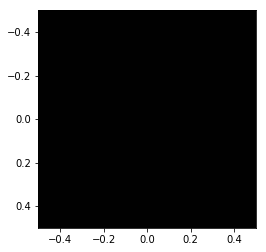

90001535


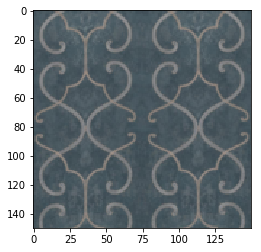

In [10]:
color_id = 8
now = COLORS[color_id]
now = now[np.newaxis, np.newaxis, :]
plt.imshow(now)
plt.show()

result = textures_backend.get_initial_images(color_id)
plt.imshow(result[2][0])
print(result[2][1])

In [11]:
best = textures_backend.get_best(color_id, [90001535])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


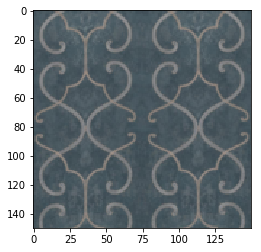

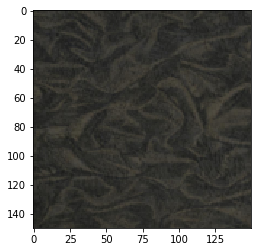

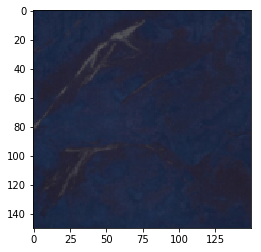

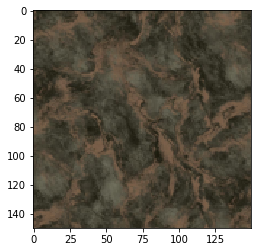

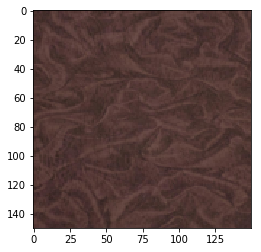

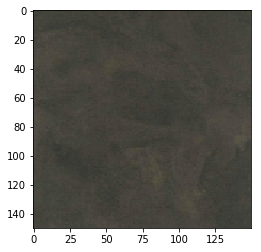

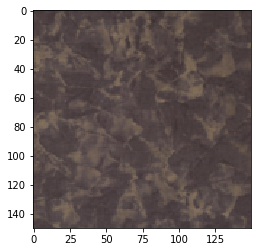

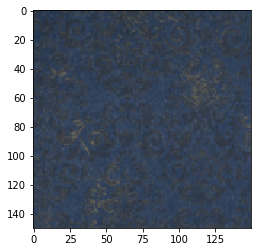

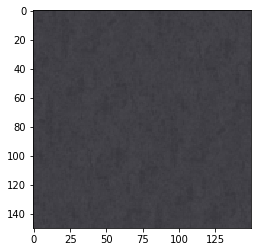

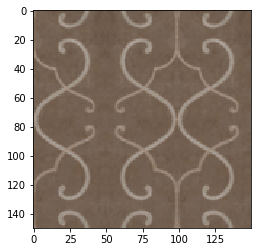

In [12]:
for value in best:
    index = textures_backend.invert_index[value]
    image = textures_backend.images[index]
    plt.imshow(image)
    plt.show()

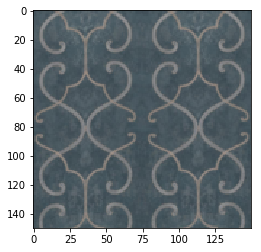

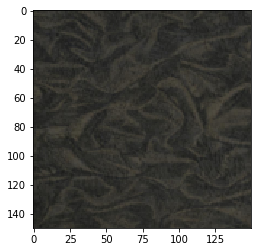

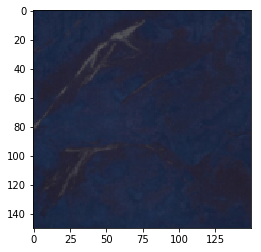

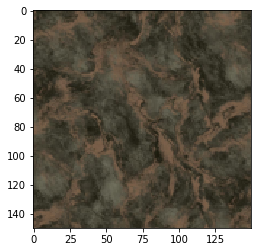

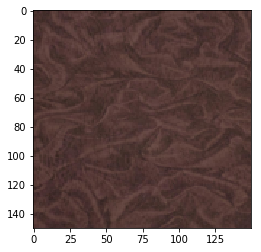

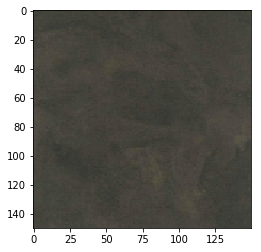

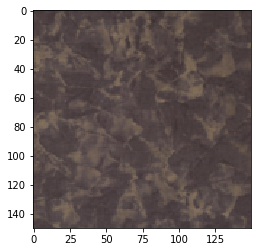

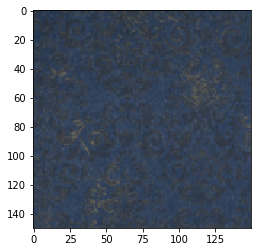

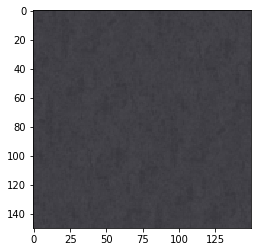

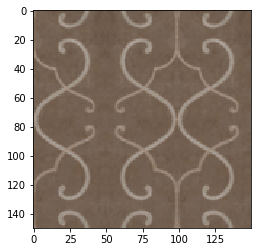

In [13]:
for value in best:
    index = textures_backend.invert_index[value]
    image = textures_backend.images[index]
    plt.imshow(image)
    plt.show()